In [1]:
import numpy as np
import matplotlib.pyplot as plt

from optic.comm.modulation import modulateGray
from optic.dsp.core import pnorm, upsample, firFilter, pulseShape, signal_power, phaseNoise, decimate
from optic.dsp.equalization import edc
from optic.models.devices import iqm, coherentReceiver
from optic.models.channels import linearFiberChannel
from optic.utils import parameters, dBm2W
from optic.plot import eyediagram, pconst

# Front-End do Receptor Coerente

Neste notebook iremos explorar um receptor óptico digital coerente típico. O front-end óptico é responsável por produzir uma saída que corresponde as componentes em fase e quadratura de duas orientações de polarização ortogonais que são representadas por correntes elétricas.

Essas correntes são convertidas em tensão e digitalizados por um conjunto de ADCs, gerando os sinais digitais que são enviados para um segundo subsistema, composto por uma cadeia de algoritmos de processamento digital de sinais (DSP) que tem por objetivo realizar as devidas compensações impostas pelo canal. 

Iremos apresentar o front-end do receptor e discutir os algoritmos usados para corrigir suas imperfeições usando métodos de enquadramento e ortogonalização.

### 4.1 The Receiver Front-end

Nos receptores ópticos, a conversão do sinal óptico em correntes elétricas é realizada pelo fotodetector. Fotodetectores são dispositivos optoeletrônicos que geram uma corrente elétrica $I_p(t)$ que é proporcional ao módulo quadrático do campo óptico de entrada $E_{in}(t)$

$$I_{p}(t)=R|E_{i n}(t)|^{2}$$

onde $R$ é uma constante de proporcionalidade chamada responsividade do fotodetector, medida em unidades de $A/W$. Em sistemas ópticos com modulação de intensidade e detecção direta, a conversão optoelétrica é realizada por um único fotodetector. Porém, um fotodetector não é capaz de recuperar a fase do campo de entrada.  Alternativamente, os receptores coerentes recorrem a estruturas mais elaboradas para recuperar a informação transmitida na amplitude, fase e polarização do sinal óptico.

Por definição receptores coerentes são estruturas que misturam um sinal de entrada na frequência $\omega_c$, com um oscilador local na frequência $\omega_{LO}$, para recuperar a fase da portadora de entrada. A mistura é uma operação não linear que converte o sinal na frequência $\omega_c$ para uma frequência intermediaria que denotamos por $\Delta\omega=\omega_{c}-\omega_{LO}$. A detecção coerente pode ser classificada em homódina, heteródina e intradina.

#### Tipos de detecção coerente

- **Detecção Homódina** ($\omega_{c}\;=\;\omega_{LO}$): a frequência do laser do transmissor e a frequência do laser oscilador local são idênticas.

- **Detecção Heteródina** ($\omega_{c}\neq\omega_{LO}$): a frequência do laser do transmissor e a frequência do laser oscilador local são diferentes.

- **Detecção intradina** ($\omega_{c}\approx\omega_{LO}$): a frequência do laser do transmissor e do laser oscilador local são "ligeiramente" diferentes.

Nos casos em que temos uma detecção intradina a conversão para banda base é realizada por algoritmos de recuperação de frequência implementados pelo DSP.

O front-end óptico de um receptor coerente é a estrutura que mistura o sinal óptico de entrada com o laser oscilador local, gerando correntes elétricas que representam as componentes de fase e quadratura do sinal recebido, esse dispositivo é denominado como *Hybrid*. Abaixo podemos observar um circuito fotônico que implementa uma híbrida.

<br>
<center>
    <img src="https://i.postimg.cc/rFFBm1Vj/Hybrid-90.png">
</center>
<br>

**Fig 01. Referência:** Digital Coherent Optical Systems: Architecture and Algorithms

O sinal óptico $E_r(t)$ é primeiro combinado com o sinal do oscilador local $E_{LO}(t)$ em um híbrido de $90°$ que consiste em quatro acopladores de 3 dB e um deslocador de fase $\pi/2$. Para entendermos a híbrida vamos começar com o modelo de função de transferência de campo de um acoplador de 3 dB dada por

$$\tilde{H}_{c}=\frac{1}{\sqrt{2}}\left[\begin{array}{c c}{{1}}&{{1}}\\ {{1}}&{{-1}}\end{array}\right]$$

Utilizando a função de transferência é possível obter as expressões do campo elétrico dos sinais ópticos nos pontos 1, 2, 3 e 4 indicados na Fig 01.

$$E_{1}(t)={\frac{1}{2}}E_{r}(t)+{\frac{1}{2}}E_{L O}(t),$$ 
$$E_{2}(t)=\frac{1}{2}E_{r}(t)+\frac{1}{2}E_{L O}(t)e^{j\pi},$$
$$E_{3}(t)=\frac{1}{2}E_{r}(t)+\frac{1}{2}E_{L O}(t)e^{j\frac{\pi}{2}},$$
$$E_{4}(t)=\frac{1}{2}E_{r}(t)+\frac{1}{2}E_{L O}(t)e^{j\frac{3\pi}{2}}.$$

A Hibrida combina $E_r(t)$ com $E_{LO}(t)$, produzindo quatro saídas com mudança de fase mutuamente em 0, $\pi/2$, $\pi$ e $3\pi/2$ rad. Os quatro sinais ópticos são recebidos independentemente por quatro fotodetectores (também conhecidos como dois fotodetectores balanceados), que são combinados para produzir duas correntes elétricas correspondentes a componentes em fase e em quadratura.

$$i_{I}(t)=i_{1}(t)-i_{2}(t)=R\,|E_{1}(t)|^{2}-R\,|E_{2}(t)|^{2}\,,$$
$$i_{Q}(t)=i_{3}(t)-i_{4}(t)=R\,|E_{3}(t)|^{2}-R\,|E_{4}(t)|^{2}\,.$$

Subistituindo $E_r(t)$ temos a saída do fotodetector balanceado

$$i_{I}(t)=R\left|{\frac{1}{2}}E_{r}(t)+{\frac{1}{2}}E_{L O}(t)\right|^{2}-R\left|{\frac{1}{2}}E_{r}(t)+{\frac{1}{2}}E_{L O}(t)e^{j\pi}\right|^{2},$$
$$i_{Q}(t)=R\left|\frac{1}{2}E_{r}(t)+\frac{1}{2}E_{L O}(t)e^{j\frac{\pi}{2}}\right|^{2}-R\left|\frac{1}{2}E_{r}(t)+\frac{1}{2}E_{L O}(t)e^{j\frac{\omega}{2}}\right|^{2}.$$

Ainda podemos simplificar utilizando a seguinte propriedade

$$|z+k|^{2}=|z|^{2}+|k|^{2}+2\mathbb{R}\{zk^{*}\}$$
$$i_{I}(t)=R\mathbb{R}\left\{E_{r}(t)E_{L O}^{*}(t)\right\}$$
$$i_Q(t) = R\mathbb{R}\left\{E_{r}(t)\left[E_{LO}(t)e^{j\pi/2}\right]^{*}\right\}$$

Se considerarmos a condição em que temos uma detecção coerente intradina é coveniente usar o chamado pré-envelope ou representação analítica de $x(t)$, $x_a(t) = x_b(t)e^{i\omega_ct}$ gerando após a detecção um sinal em frequência intermediária $\Delta\omega$. Assim, assumindo que $E_r(t)$ possui uma modulação de amplitude $A_r(t)$ e uma modulação de fase $\phi_r(t)$, é possível escrever o pré-envelope do sinal recebido como:

$$E_r(t) = A_{r}\left(t\right)e^{j\left[\phi_{r}\left(t\right)+\omega_{c}t\right]}$$

Além disso, assumindo um oscilador local ideal,

$$E_{LO}(t) = A_{LO}\left(t\right)e^{j\left[j\omega_{LO}t\right]}$$

Assim podemos reescrever as correntes $i_{I}(t)$ e $i_{Q}(t)$ como,

$$i_{I}(t)=A_{r}(t)A_{LO}R\mathbb{R}\left\{e^{j[\phi_{r}(t)+\Delta\omega t]}\right\}=A_{r}(t)A_{LO}R\mathrm{cos}(\phi_{r}(t)+\Delta\omega t)$$
$$i_{Q}(t)=A_{r}(t)A_{LO}R\mathbb{R}\left\{e^{j[\phi_{r}(t)+\Delta\omega t-\pi/2]}\right\}=A_{r}(t)A_{L O}R\sin(\phi_{r}(t)+\Delta\omega t)$$

#### Sinal complexo detectado

$$s(t) = i_I(t) + ji_Q(t)$$
$$s(t) = A_{r}(t)A_{LO}R(\mathrm{cos}(\phi_{r}(t)+\Delta\omega t) + j\sin(\phi_{r}(t)+\Delta\omega t))$$
$$s(t) = A_{r}(t)A_{LO}Re^{j(\phi_{r}(t)+\Delta\omega t)}$$

Sabendo que $\Delta\omega=\omega_{c}-\omega_{LO}$

$$s(t) = A_{r}(t)A_{LO}Re^{j(\phi_{r}(t)+(\omega_{c}-\omega_{LO})t)}$$

### Simulação: transmissão coerente M-QAM

In [68]:
# Parâmetros da simulação.
M = 4                   # Ordem da modulação
constType = 'qam'       # Esquema de modulação
pulseType = 'rc'        # Pulso a ser utilizado
Rs = 10e9               # Taxa de símbolos [símbolo/s]
Ts = 1/Rs               # Período de símbolo em segundos
SpS = 32                # Amostras por símbolo
Fa = 1/(Ts/SpS)         # Frequência de amostragem do sinal [amostras/segundo]
Ta = 1/Fa               # Período de amostragem
Ncoeff = 4096           # Número de coeficientes do filtro RC
alpha = 0.01            # Rolloff

# parâmetros do IQM
paramIQM = parameters()
paramIQM.Vπ = 2 
paramIQM.Vb = -paramIQM.Vπ

# parâmetros da fibra
paramFiber = parameters()
paramFiber.L = 70e3         # comprimento do enlace [m]
paramFiber.alpha = 0        # coeficiente de perdas [dB/Km]
paramFiber.D = 18e-6        # parâmetro de dispersão
paramFiber.Fc = 193.1e12    # frequência central [Hz]
paramFiber.Fs = Fa          # Frequência de amostragem do sinal [amostras/segundo]

# parâmetros do receptor
B  = 10e9                   # banda do receptor em Hz
Plo_dBm  = 10               # potência do oscilador local
Δf_lo    = 0                # desvio de frequência do oscilador local
ϕ_lo     = 0                # fase do oscilador local
lw       = 0*10e3           # largura de linha do laser

Plo = 10**(Plo_dBm/10)*1e-3 # potência do oscilador local na entrada do receptor

In [69]:
# gera uma sequência de bits pseudo-aleatórios que chegam ao transmissor
bitsTx = np.random.randint(2, size = int(1e5*np.log2(M)))

# Gera o mapeamento dos bits para símbolos M-PAM
symbTx = modulateGray(bitsTx, M, constType)    
symbTx = pnorm(symbTx) # power normalization

symbolsUp = upsample(symbTx, SpS)

# seleciona o pulso desejado.
if pulseType == "nrz" or pulseType == "rect":
    pulse = pulseShape(pulseType, SpS)
elif pulseType == "rc":
    pulse = pulseShape(pulseType, SpS, Ncoeff, alpha, Ts)

pulse = pulse/max(np.abs(pulse))
# formatação de pulso
sigTx = firFilter(pulse, symbolsUp)

# Laser power
Pi = 100e-3  # potência óptica do laser na entrada do IQM

# optical modulation
Ai = np.sqrt(Pi)
sigTxo_ = iqm(Ai, 0.5*paramIQM.Vπ*sigTx, paramIQM)

# adiciona ruído ASE ao sinal óptico
σ2ASE  = 1e-10
σ2 = σ2ASE*(Fa/B)
ruido = np.random.normal(0, np.sqrt(σ2), sigTxo_.size) + 1j*np.random.normal(0, np.sqrt(σ2), sigTxo_.size)

sigTxo = sigTxo_ + 0*ruido

print('Potência média do sinal óptico modulado [mW]: %.3f mW'%(signal_power(sigTxo)/1e-3))
print('Potência média do sinal óptico modulado [dBm]: %.3f dBm'%(10*np.log10(signal_power(sigTxo)/1e-3)))

Potência média do sinal óptico modulado [mW]: 25.998 mW
Potência média do sinal óptico modulado [dBm]: 14.149 dBm


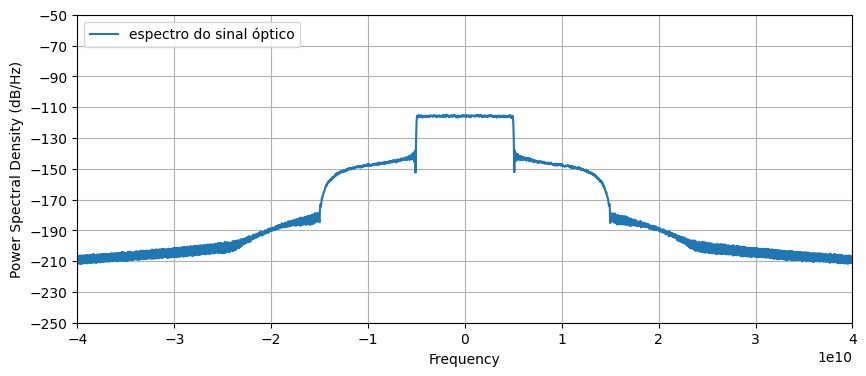

In [70]:
# plot psd
plt.figure(figsize=(10, 4))
plt.xlim(-4*Rs, 4*Rs)
plt.ylim(-250, -50)
plt.psd(sigTxo, Fs=Fa, NFFT = 16*1024, sides='twosided', label = 'espectro do sinal óptico')
plt.legend(loc='upper left');

In [71]:
# canal óptico linear
sigRxo = linearFiberChannel(sigTxo, paramFiber)

# recepcão coerente
Pin = signal_power(sigTxo) # Potência óptica média média recebida

# oscilador local
t = np.arange(0, sigRxo.size)*Ta
ϕ_pn_lo = phaseNoise(lw, sigRxo.size, Ta)

sigLO = np.sqrt(Plo)*np.exp(1j*(2*np.pi*Δf_lo*t + ϕ_lo + ϕ_pn_lo))

# receptor coerente devolve as componentes de fase e quadratura através de uma hibrida.
sigRx_ = coherentReceiver(sigRxo, sigLO)
# filtragem Rx
sigRx = firFilter(pulse, sigRx_)

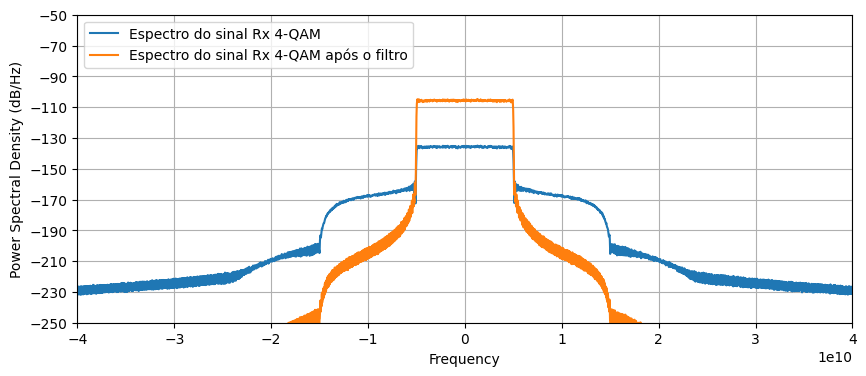

In [72]:
plt.figure(figsize=(10, 4));
plt.ylim(-250, -50);
plt.psd(sigRx_, Fs=Fa, NFFT = 16*1024, sides='twosided', label = 'Espectro do sinal Rx '+str(M)+'-'+str(constType).upper())
plt.psd(sigRx,  Fs=Fa, NFFT = 16*1024, sides='twosided', label = 'Espectro do sinal Rx '+str(M)+'-'+str(constType).upper()+' após o filtro')
plt.legend(loc='upper left');
plt.xlim(-4*Rs,4*Rs);

In [73]:
# compensa dispersão cromática
sigRx = edc(sigRx, paramFiber)

# captura amostras no meio dos intervalos de sinalização
paramDec = parameters()
paramDec.SpS_in = SpS
paramDec.SpS_out = 1
sigRx = decimate(sigRx.reshape(-1,1), paramDec).reshape(-1,)

discard = 2000
ind = np.arange(discard, sigRx.size-discard)

# normaliza constelação recebida
sigRx = pnorm(sigRx)

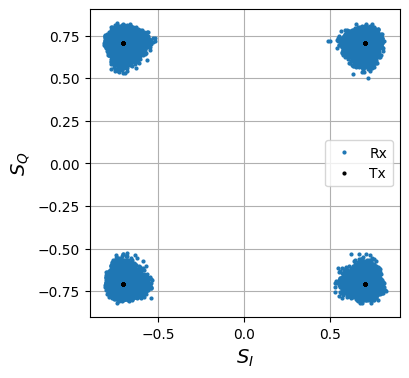

In [74]:
plt.figure(figsize=(4,4))
plt.ylabel('$S_Q$', fontsize=14)
plt.xlabel('$S_I$', fontsize=14)
plt.grid()

plt.plot(sigRx[ind].real, sigRx[ind].imag, '.', markersize=4, label='Rx')
plt.plot(symbTx[ind].real, symbTx[ind].imag,'k.', markersize=4, label='Tx');
plt.legend()